In [1]:
import sys 
import joblib
sys.path.append('/home/samuel.varga/python_packages/wofs_ml_severe')
sys.path.append('/home/samuel.varga/python_packages/WoF_post')
sys.path.append('/home/samuel.varga/python_packages/scikit-explain')
sys.path.append('/home/samuel.varga/projects/2to6_hr_severe_wx/experiments')
sys.path.append('/home/samuel.varga/python_packages/MontePython/')

from ml_2to6_data_pipeline import (GridPointExtracter,
                                                       subsampler, 
                                                       load_dataset, random_subsampler)
from os.path import join, exists
import argparse
#Appendages
sys.path.append('/home/samuel.varga/projects/2to6_hr_severe_wx/')
sys.path.append('/home/samuel.varga/python_packages/ml_workflow/')
sys.path.append('/home/samuel.varga/python_packages/VargaPy/')
# Import packages 
import pandas as pd
import numpy as np
import sklearn
from os.path import join
from sklearn.linear_model import LogisticRegression
from hyperopt import hp
from main.io import load_ml_data
from ml_workflow.calibrated_pipeline_hyperopt_cv import norm_aupdc_scorer, norm_csi_scorer
from ml_workflow.tuned_estimator import TunedEstimator, dates_to_groups
from VargaPy.MlUtils import All_Severe, Drop_Unwanted_Variables, Train_Ml_Parser, group_coefs
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt

lookup_file: /home/samuel.varga/python_packages/WoF_post/wofs/data/psadilookup.dat


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Load data

In [14]:
%matplotlib inline
FRAMEWORK='POTVIN'
TIMESCALE='0to3'
target_scale='36'
base_path = f'/work/samuel.varga/data/{TIMESCALE}_hr_severe_wx/{FRAMEWORK}'
X,y,metadata = All_Severe(base_path, mode='train',
                                  target_scale=target_scale,
                                  FRAMEWORK=FRAMEWORK,
                                  TIMESCALE=TIMESCALE, SigSevere=False)
X, ts_suff = Drop_Unwanted_Variables(X, original=False, training_scale=False, intrastormOnly=False, envOnly=False)

35388
63121
66309
Using new variables- dropping old 90th percentile
(1362800, 174)
all


## Plot Coefficient Ranks

In [15]:
from skexplain.common.importance_utils import to_skexplain_importance
import skexplain
model_ind=0
base_path=f'/work/samuel.varga/projects/{TIMESCALE}_hr_severe_wx/{FRAMEWORK}'
model=joblib.load(join(base_path, f'mlModels/{target_scale}km/Varga_all_logistic_all_{target_scale}km_control_{model_ind}.joblib'))

# X and y are the training dataset
explainer = skexplain.ExplainToolkit(X=X,y=y)
coefs = model['model'].calibrated_classifiers_[0].base_estimator.named_steps['model'].coef_[0]

In [34]:
Z=group_coefs(X.columns, coefs)
Z=Z.groupby(['variable','neighborhood']).sum().reset_index() #variable, category, neighborhood, statistic
Z.sort_values(by='coef', ascending=False)

,variable,neighborhood,coef
13,low_level_lapse_rate,45km,1.848932
43,srh_0to3,45km,1.646495
12,low_level_lapse_rate,27km,1.310629
42,srh_0to3,27km,1.276434
25,shear_u_0to1,45km,0.871915
...,...,...,...
17,mid_level_lapse_rate,9km,0.082554
56,w_up,9km,0.071717
50,uh_0to2_instant,9km,0.060566
20,okubo_weiss,9km,0.051792


In [25]:
names=np.array(Z.statistic)
coefs_=np.array(Z.coef)

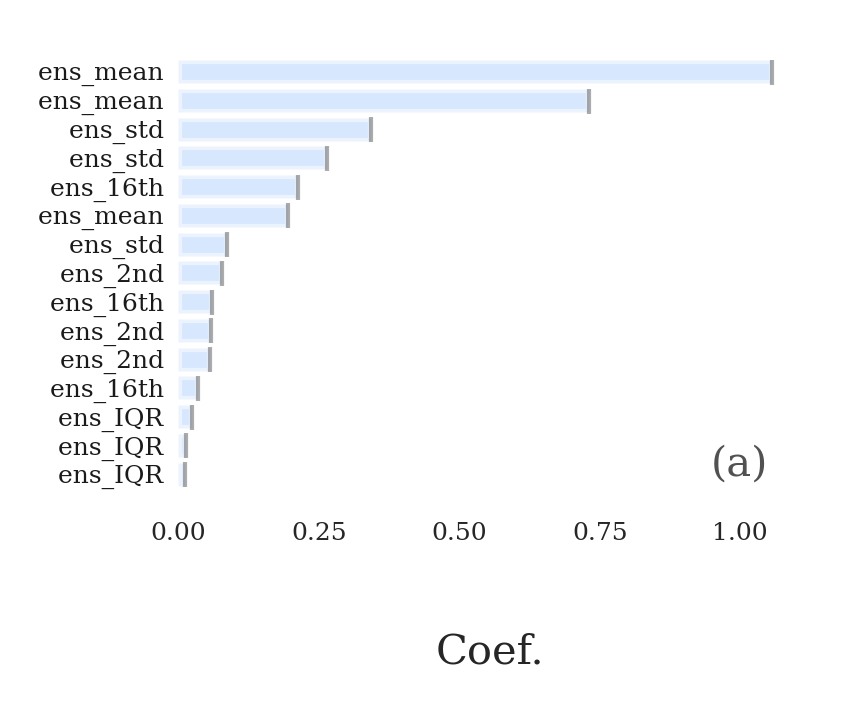

In [26]:
coef_rank = to_skexplain_importance(coefs_,
                                       estimator_name='LogisticRegression', 
                                       feature_names=names, 
                                        method = 'coefs')

panels = [('coefs', 'LogisticRegression')]
fig = explainer.plot_importance(data=coef_rank, panels=panels, 
                                num_vars_to_plot=20, 
                               )

In [95]:
dir(model['model'])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_feature_names',
 '_check_n_features',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_validate_data',
 'base_estimator',
 'calibrated_classifiers_',
 'classes_',
 'cv',
 'ensemble',
 'feature_names_in_',
 'fit',
 'get_params',
 'method',
 'n_features_in_',
 'n_jobs',
 'predict',
 'predict_proba',
 'score',
 'set_params']

In [107]:
model['model'].get_params()

{'base_estimator__memory': None,
 'base_estimator__steps': [('imputer', SimpleImputer(strategy='median')),
  ('scaler', StandardScaler()),
  ('model',
   LogisticRegression(l1_ratio=0.001, max_iter=300, penalty='elasticnet',
                      random_state=42, solver='saga'))],
 'base_estimator__verbose': False,
 'base_estimator__imputer': SimpleImputer(strategy='median'),
 'base_estimator__scaler': StandardScaler(),
 'base_estimator__model': LogisticRegression(l1_ratio=0.001, max_iter=300, penalty='elasticnet',
                    random_state=42, solver='saga'),
 'base_estimator__imputer__add_indicator': False,
 'base_estimator__imputer__copy': True,
 'base_estimator__imputer__fill_value': None,
 'base_estimator__imputer__missing_values': nan,
 'base_estimator__imputer__strategy': 'median',
 'base_estimator__imputer__verbose': 0,
 'base_estimator__scaler__copy': True,
 'base_estimator__scaler__with_mean': True,
 'base_estimator__scaler__with_std': True,
 'base_estimator__model__C'

In [32]:
model['model'].calibrated_classifiers_[0].base_estimator.named_steps['model'].coef_[0]

array([-5.85146692e-02, -3.90471169e-03,  2.25764950e-02,  3.93726876e-01,
        4.79390657e-02, -2.76779636e-02, -1.03230396e-01, -4.21247399e-02,
       -2.07242032e-02, -2.71399235e-04, -2.39516307e-02,  6.50043084e-01,
        6.77962404e-02,  2.09890591e-01, -1.08291074e-01, -4.29343610e-04,
        9.57823312e-03, -9.47798089e-02,  2.01531424e-01,  3.32865292e-01,
        2.36622642e-01,  3.96313932e-02, -2.71982718e-02, -3.83302743e-02,
       -1.36690818e-02,  3.12906781e-02,  3.92171100e-02, -9.32630212e-03,
        1.53430985e-02, -4.48242832e-02,  1.08960250e-02,  6.41928879e-03,
        3.33375849e-02, -1.13020181e-03,  5.61569873e-03,  5.78819314e-02,
       -9.32132582e-04, -3.83505535e-02,  2.93197662e-02,  1.39658839e-02,
        1.00481017e-03,  9.32966251e-03,  2.29829963e-02, -3.70325267e-01,
        1.75453665e-01, -1.60594037e-01,  1.60660850e-01,  3.06909305e-01,
       -8.19182723e-02, -1.87922186e-01,  2.49889601e-01,  1.89071294e-01,
       -2.84480247e-01,  